In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

print('Check if we are using TensorFlow 2.4')
print('Using TensorFlow version', tf.__version__)
print(tf.config.list_physical_devices('GPU'))

np.random.seed(42)

Check if we are using TensorFlow 2.4
Using TensorFlow version 2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Process Objects and Textures

(112, 96, 4)


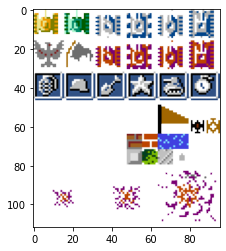

In [2]:
sprites = plt.imread('sprites.gif')
print(sprites.shape)
plt.imshow(sprites)

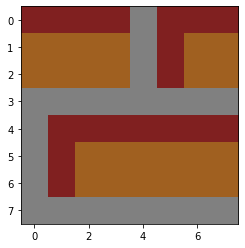

In [3]:
bs = 8
brick = sprites[bs*8:bs*9,bs*6:bs*7]
plt.imshow(brick)

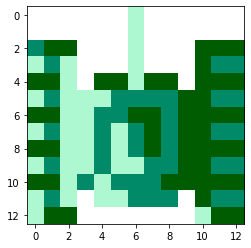

In [4]:
tank = sprites[:bs*2-3,bs*2:bs*4-3]
plt.imshow(tank)

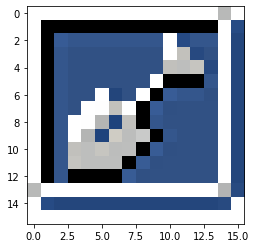

In [5]:
objects = {
    'tanks': [sprites[:bs*2-3, bs*2*i:bs*2*i+bs*2-3] for i in range(2)],
    'enemies': [sprites[:bs*2-1,bs*2*i:bs*2*i+bs*2-3] for i in range(2,6)],
    'boosted_enemies': [sprites[bs*2:bs*4-1,bs*2*i:bs*2*i+bs*2-3] for i in range(2,6)],
    'base': [sprites[bs*2:bs*4-2,bs*2*i:bs*2*i+bs*2] for i in range(2)],
    'bonuses': [sprites[bs*4:bs*6,bs*2*i:bs*2*i+bs*2] for i in range(6)],
}
textures = {
    'brick': sprites[bs*8:bs*9,bs*6:bs*7],
    'water': sprites[bs*8:bs*9,bs*8:bs*9],
    'steel': sprites[bs*9:bs*10,bs*6:bs*7],
    'bush': sprites[bs*9:bs*10,bs*7:bs*8],
    'ice': sprites[bs*9:bs*10,bs*8:bs*9],
}
other = {
    'bullet': [],
    'explodions': [],
    'effects':[],
}

plt.imshow(objects['bonuses'][2])
#objects['bonuses'][2]

### Map Generation

In [6]:
n_maps = 35
maps = np.empty((n_maps,26), dtype='<U26')

for i in range(n_maps):
    with open(f'levels/{i+1}', "r") as f:
        data = f.read().split("\n")
        maps[i, :] = np.array(data)

print(maps.shape)
maps[0]

(35, 26)


array(['..........................', '..........................',
       '..##..##..##..##..##..##..', '..##..##..##..##..##..##..',
       '..##..##..##..##..##..##..', '..##..##..##..##..##..##..',
       '..##..##..##@@##..##..##..', '..##..##..##@@##..##..##..',
       '..##..##..##..##..##..##..', '..##..##..........##..##..',
       '..##..##..........##..##..', '..........##..##..........',
       '..........##..##..........', '##..####..........####..##',
       '@@..####..........####..@@', '..........##..##..........',
       '..........######..........', '..##..##..######..##..##..',
       '..##..##..##..##..##..##..', '..##..##..##..##..##..##..',
       '..##..##..##..##..##..##..', '..##..##..........##..##..',
       '..##..##..........##..##..', '..##..##...####...##..##..',
       '...........#..#...........', '...........#..#...........'],
      dtype='<U26')

In [7]:
def build_city():
    data = maps[np.random.randint(n_maps)]
    
    city = np.zeros((26*bs, 26*bs, 4)).astype('uint8')
    city[:,:,3]=255
    
    #textures
    for i, row in enumerate(data):
        for j, c in enumerate(row):
            if c == '#':
                tx = textures['brick'].copy()
            elif c == '@':
                tx = textures['steel'].copy()
            elif c == '%':
                tx = textures['bush'].copy()
            elif c == '~':
                tx = textures['water'].copy()
            elif c == '-':
                tx = textures['ice'].copy()
            else:
                continue

            city[bs*i:bs*(i+1), bs*j:bs*(j+1), :] = tx
    
    #tank
    class_id = np.random.randint(2)
    
    if class_id == 0:
        c1 = np.random.randint(208-13)
        c2 = np.random.randint(208-13)
        city[c1:c1+13, c2:c2+13, :] = objects['tanks'][0].copy()
    else:
        c1 = np.random.randint(208-15)
        c2 = np.random.randint(208-13)
        city[c1:c1+15, c2:c2+13, :] = objects['enemies'][3].copy()
    
    return city[:,:,:3], class_id, (c1, c2)

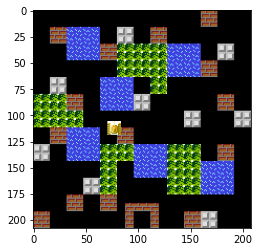

In [8]:
city, class_id, tank_coords = build_city()
        
plt.imshow(city)

$208 \times 208$

In [9]:
def plot_bounding_box(image, gt_coords, pred_coords=[], norm=False):
    row, col = gt_coords
    
    if norm:
        row *= 208
        col *= 208
        image *= 255.
        image = image.astype('uint8')
        
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    
    
    #row *= 208
    #col *= 208
    draw.rectangle((col-3, row-3, col + 15, row + 15), outline='#4CFF52', width=3) #4CFF52
    
    
    if len(pred_coords) == 2:
        row, col = pred_coords
        #row *= 208
        #col *= 208
        draw.rectangle((col-3, row-3, col + 15, row + 15), outline='#FF229A', width=3) #FF229A
        
    return image

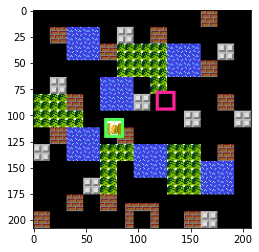

In [24]:
image = plot_bounding_box(city, tank_coords, (80, 120))
plt.imshow(image)

In [27]:
def data_generator(batch_size=16):
    while True:
        x_batch = np.zeros((batch_size, 208, 208, 3))
        y_batch = np.zeros((batch_size, 2))
        bbox_batch = np.zeros((batch_size, 2))
        
        for i in range(0, batch_size):
            image, class_id, (row, col) = build_city()

            x_batch[i] = image / 255.
            y_batch[i, class_id] = 1.
            bbox_batch[i] = np.array((row/208, col/208))
        
        yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch} # inputs, outputs

Text(0.5, 1.0, '0')

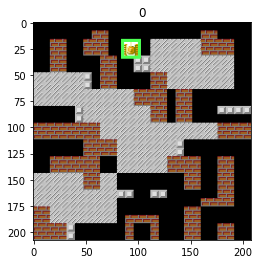

In [28]:
example, label = next(data_generator(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image = plot_bounding_box(image, coords, norm=True)
plt.imshow(image)
plt.title(class_id)

In [30]:
input_ = Input(shape=(208, 208, 3), name='image')

x = input_

for i in range(0, 3):
    n_filters = 2**(1 + i)
    # n_filters = 2**(4 + i)
    x = Conv2D(n_filters, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)
    
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
    
class_out = Dense(2, activation='softmax', name='class_out')(x)
box_out = Dense(2, name='box_out')(x)

model = tf.keras.models.Model(input_, [class_out, box_out])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 208, 208, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 206, 206, 2)  56          ['image[0][0]']                  
                                                                                                  
 batch_normalization_10 (BatchN  (None, 206, 206, 2)  8          ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                            

### Metric: IoU

In [31]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(IoU, self).__init__(**kwargs)
        
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        def get_box(y):
            rows, cols = y[:, 0], y[:, 1]
            rows, cols = rows * 144, cols * 144
            y1, y2 = rows, rows + 52
            x1, x2 = cols, cols + 52
            
            return x1, y1, x2, y2
            
        def get_area(x1, y1, x2, y2):
            return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)
            
        gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
        p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)
        
        i_x1 = tf.maximum(gt_x1, p_x1)
        i_y1 = tf.maximum(gt_y1, p_y1)
        i_x2 = tf.minimum(gt_x2, p_x2)
        i_y2 = tf.minimum(gt_y2, p_y2)
        
        i_area = get_area(i_x1, i_y1, i_x2, i_y2)
        u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area
        
        iou = tf.math.divide(i_area, u_area)
        
        self.num_ex.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))              # ???
        self.iou = tf.math.divide(self.total_iou, self.num_ex)
        
    def result(self):
        return self.iou
    
    def reset_state(self):
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

## Task 8: Compile the Model

In [32]:
model.compile(
    loss={
        'class_out': 'categorical_crossentropy',
        'box_out': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics={
        'class_out': 'accuracy',
        'box_out': IoU(name='iou')
    }
)

## Task 9: Custom Callback: Model Testing

In [33]:
def test_model(model, test_datagen):
    example, label = next(test_datagen)
    x = example['image']
    y = label['class_out']
    box = label['box_out']
    
    pred_y, pred_box = model.predict(x)
    
    pred_coords = pred_box[0]
    gt_coords = box[0]
    
    pred_class = np.argmax(pred_y[0])
    gt_class = np.argmax(y[0])
    
    image = x[0]
    
    gt = 'tank' if gt_class == 0 else 'enemy'
    pred_class_name = 'tank' if gt_class == 0 else 'enemy'
    
    image = plot_bounding_box(image, gt_coords, pred_coords, norm=True)
    color = 'green' if gt == pred_class_name else 'red'
    
    plt.imshow(image)
    plt.xlabel(f'Pred: {pred_class_name}', color=color)
    plt.ylabel(f'GT: {gt}', color=color)
    plt.xticks([])
    plt.yticks([])
    

In [34]:
def test(model):
    test_datagen = data_generator(1)
    
    plt.figure(figsize=(16, 4))
    
    for i in range(0, 6):
        plt.subplot(1, 6, i + 1)
        test_model(model, test_datagen)
        
    plt.show()

1/1 [==============================] - 0s 22ms/step


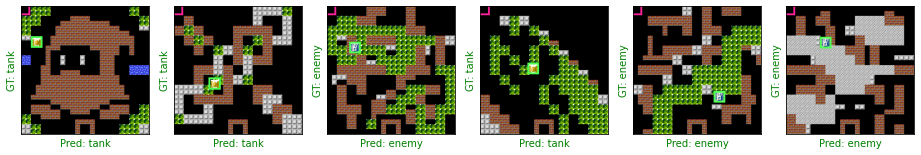

In [35]:
test(model)

In [36]:
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

## Task 10: Model Training

In [37]:
def lr_schedule(epoch, lr):
    if (epoch + 1) % 10 == 0:
        lr *= 0.2
        
    return max(lr, 3e-7)

Epoch 1/50
1/1 [==============================] - 0s 18ms/step


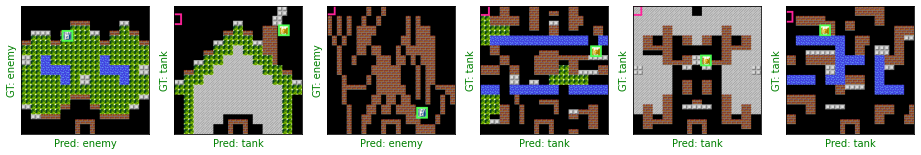

500/500 [==============================] - 19s 36ms/step - loss: 28.2005 - class_out_loss: 1.0011 - box_out_loss: 27.1994 - class_out_accuracy: 0.4890 - box_out_iou: 0.1701 - lr: 0.0100
Epoch 2/50
1/1 [==============================] - 0s 18ms/step


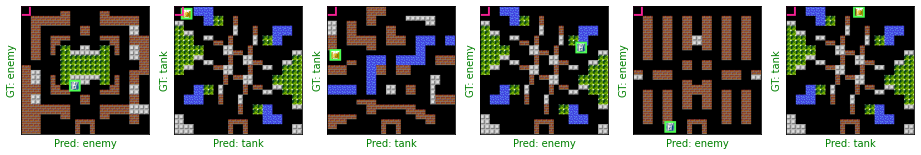

500/500 [==============================] - 19s 37ms/step - loss: 0.7948 - class_out_loss: 0.7114 - box_out_loss: 0.0833 - class_out_accuracy: 0.5056 - box_out_iou: 0.1743 - lr: 0.0100
Epoch 3/50
1/1 [==============================] - 0s 17ms/step


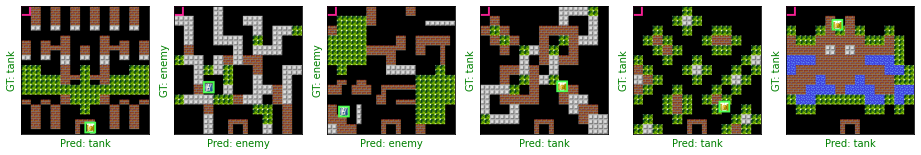

500/500 [==============================] - 20s 39ms/step - loss: 0.7661 - class_out_loss: 0.7004 - box_out_loss: 0.0657 - class_out_accuracy: 0.5002 - box_out_iou: 0.1763 - lr: 0.0100
Epoch 4/50
1/1 [==============================] - 0s 20ms/step


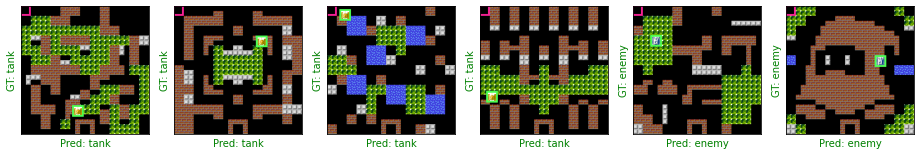

500/500 [==============================] - 19s 38ms/step - loss: 0.7547 - class_out_loss: 0.6977 - box_out_loss: 0.0571 - class_out_accuracy: 0.4951 - box_out_iou: 0.1795 - lr: 0.0100
Epoch 5/50
1/1 [==============================] - 0s 24ms/step


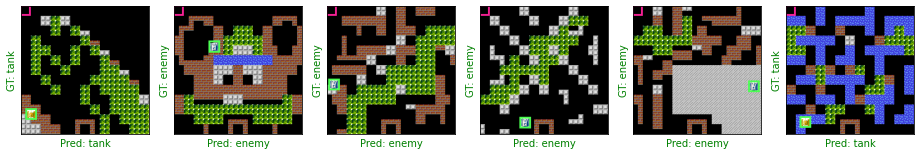

500/500 [==============================] - 24s 47ms/step - loss: 0.7580 - class_out_loss: 0.6977 - box_out_loss: 0.0603 - class_out_accuracy: 0.5074 - box_out_iou: 0.1823 - lr: 0.0100
Epoch 6/50
 57/500 [==>...........................] - ETA: 22s - loss: 0.7564 - class_out_loss: 0.6998 - box_out_loss: 0.0566 - class_out_accuracy: 0.4638 - box_out_iou: 0.1826

KeyboardInterrupt: 

In [38]:
_ = model.fit(
    data_generator(),
    epochs=50,
    steps_per_epoch=500,
    callbacks=[
        ShowTestImages(),
        tf.keras.callbacks.EarlyStopping(monitor='box_out_iou', patience=3, mode='max'),
        tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)